## Intro to NuisanceFlatTree
This notebook introduces methods to extract neutrino event info from the analysis.NuisanceFlatTree class.

In [1]:
import sys
# Change this path to your working directory where BDTReweight is installed:
sys.path.append('/exp/minerva/app/users/zihaolin/REWEIGHTworkdir/')

from BDTReweight.analysis import transform_momentum_to_reaction_frame, create_dataframe_from_nuisance
from BDTReweight.nuisance_flat_tree import NuisanceFlatTree
import matplotlib.pyplot as plt

### NUISANCE flat tree root file
NUISANCE flat tree is an event record root file that stores high level neutrino interaction event informations, see https://nuisance.hepforge.org/.

In each NUISANCE flat tree file, one can access tree (TTree)
* 'FlatTree_VARS'

with branches (TBranch)
* Event level info (1d array; length = number of events): 
    * 'Mode', 'cc', 'PDGnu', 'Enu_true', 'tgt', 'tgta', 'tgtz', 'PDGLep', 'ELep', 'CosLep', 'Q2', 'q0', 'q3', 'Enu_QE', 'Q2_QE', 'W_nuc_rest', 'W', 'W_genie', 'x', 'y', 'Eav', 'EavAlt', 'CosThetaAdler', 'PhiAdler', 'dalphat', 'dpt', 'dphit', 'pnreco_C', 'nfsp', 'ninitp', 'nvertp'
    'Weight', 'InputWeight', 'RWWeight', 
    'fScaleFactor', 'CustomWeight', 'CustomWeightArray', 
    'flagCCINC', 'flagNCINC', 'flagCCQE', 'flagCC0pi', 
    'flagCCQELike', 'flagNCEL', 'flagNC0pi', 'flagCCcoh', 
    'flagNCcoh', 'flagCC1pip', 'flagNC1pip', 'flagCC1pim', 
    'flagNC1pim', 'flagCC1pi0', 'flagNC1pi0', 
    'flagCC0piMINERvA', 'flagCC0Pi_T2K_AnaI', 
    'flagCC0Pi_T2K_AnaII', 
* Particle level info (nested array, since events can have different number of particles; length = number of events):
    * Initial state particles:
        * 'px_init', 'py_init', 'pz_init', 'E_init', 'pdg_init'
    * Vertex particles:
        * 'px_vert', 'py_vert', 'pz_vert', 'E_vert', 'pdg_vert'
    * Final state particles:
        * 'px', 'py', 'pz', 'E', 'pdg', 'pdg_rank'

### NuisanceFlatTree class
BDTReweight.analysis.NuisanceFlatTree is a class that encapsulates functions to manipulate the above quantities.

In [ ]:
# Try the small size sample with only 1000 events comes with this repository:
# tree = NuisanceFlatTree('nuisance_samples/Flattened_GENIE_v2_12_6_DefaultMEC_numu_CH_105_ghep_small.root')

# Or try the full 1000,000 events sample if you are on MINERvA GPVM:
tree = NuisanceFlatTree('/pnfs/minerva/persistent/Models/GENIE/Medium_Energy/FHC/v2_12_6/tracker/minervabase/Flattened_GENIE_v2_12_6_DefaultMEC_numu_CH_105_ghep.root')    

# Or try to load from a list of root files:
# tree = NuisanceFlatTree(
#     ['/pnfs/minerva/persistent/Models/GENIE/Medium_Energy/FHC/v2_12_6/tracker/minervabase/Flattened_GENIE_v2_12_6_DefaultMEC_numu_CH_105_ghep.root',
#     '/pnfs/minerva/persistent/Models/GENIE/Medium_Energy/FHC/v2_12_6/tracker/minervabase/Flattened_GENIE_v2_12_6_DefaultMEC_numu_CH_106_ghep.root']
# )

### Event entry masks
Masks are 1d float or boolean arrays with length = number of events in the tree.
You can create masks to filter out events of your interests.

For example, NuisanceFlatTree.get_mask_CCQELike() returns a mask for CCQE-like events in the flat tree.

More masks will be implemented in the future.

In [3]:
# Get array masking for CCQE-like events:
mask_CCQELike = tree.get_mask_CCQELike()

# Update tree such that we only focus on masked CCQE-like event entries:
tree.update_tree_with_mask(mask_CCQELike)
# ! Note: Unmasked events are discarded.


In [4]:
# Get tree content - an awkward.Array:
tree.get_tree_array()

<Array [{Mode: 1, cc: 1, PDGnu: 14, ...}, ...] type='90510 * {Mode: int32, ...'>

### Event entry masks: final state topology and particle counting
You can customize a mask for events that follows the final state topology pattern you defined.
Specify the final state particle names such as:
* 'muon', 'electron', 'proton', 'neutron', 'photon', 'pi+', 'pi-', 'pi0'

and counting rules to apply, in the form of:
* '>x', '>=x', '==x', '<=x', '\<x', 

where x is an integer. 

Only those particles above their kinetic energy thresholds (default: 0.0 GeV) are counted.

In [5]:
# Specify proton, neutron detecting threshold to be 0.05 GeV and 0.01 GeV (for MINERvA detector):
KE_thresholds={'proton':0.05, 'neutron':0.01}
# Only those above threshold are counted in final state topology. Default threshold is 0.0 GeV.

# Specify counting rules for each particle of intesest in dictionary form, i.e., {particle:rule},
# where rules are partial logical clauses to be applied to particle counts:
particle_counts = {'muon':'==1', 'proton':'==1', 'neutron':'>0'}

# Get masking for 1mu1pNn final state topology events:
mask_1mu1pNn = tree.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)

### Extract physical quantities from NUISANCE flat tree using query expressions
To extract and create pandas DataFrame for quantities such as leading proton's momentum, a naming convention for particle level variables is defined. 
All query info are encapsulated in string query expressions in the form of
* 'selector_particle_variable'

where fields 'selector', 'particle', and 'variable' are seperated by '_'.

'selector' options:
* 'leading', 'subleading', 'total'

Meaning most energetic particle, second most energetic particle, or sum over all particles (in final state). 

'particle' options:
* 'muon', 'electron', 'proton', 'neutron', 'photon', 'pip', 'pim', 'pi0'

'variable' options:

* 'px', 'py', 'pz', 'E', 'KE'

More options will be implemented in the future.

To get final state leading proton's px and sum of all neutron's KE, for example, use expressions:
* 'leading_proton_px', 'total_neutron_KE'

Alternatively, query expressions can be any NUISANCE branch keys, such as 'Mode', 'flagCCQELike', etc. 
Note that particle level quantities are nested arrays, so they can leads to errors when pull into pandas DataFrame. 



In [6]:
# List variables in 'selector_particle_variable' form to extract from tree: 
variable_exprs = ['leading_muon_px', 'leading_muon_py', 'leading_muon_pz',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz', 
    'total_proton_px', 'total_proton_py', 'total_proton_pz'
]

# Extract these variables from 1mu1pNn events in the flat tree: 
df = create_dataframe_from_nuisance(tree, variable_exprs=variable_exprs, mask=mask_1mu1pNn)
df

,leading_muon_px,leading_muon_py,leading_muon_pz,leading_proton_px,leading_proton_py,leading_proton_pz,subleading_proton_px,subleading_proton_py,subleading_proton_pz,total_proton_px,total_proton_py,total_proton_pz
0,0.308619,-0.687037,3.731666,0.003915,0.339757,-0.212860,NaN,NaN,NaN,0.003915,0.339757,-0.212860
1,0.379449,-0.507505,8.826530,-0.252646,-0.223257,0.102860,0.259610,0.105676,-0.124282,-0.216631,0.080599,0.058802
2,-0.033186,0.916631,13.146617,0.082258,0.208821,0.278977,NaN,NaN,NaN,0.082258,0.208821,0.278977
3,0.311058,0.698361,6.288555,-0.118732,-0.479989,0.311977,NaN,NaN,NaN,-0.118732,-0.479989,0.311977
4,-0.466626,-0.721124,2.898577,0.274685,0.518479,0.141794,0.112386,0.136136,0.048795,0.329401,0.752478,0.265695
...,...,...,...,...,...,...,...,...,...,...,...,...
12062,0.162134,-0.501028,1.890124,-0.229601,0.215497,0.142499,0.058377,0.111956,0.257984,-0.251075,0.288176,0.392226
12063,-0.663891,1.042299,3.629218,0.604566,-0.815804,1.135061,NaN,NaN,NaN,0.604566,-0.815804,1.135061
12064,-0.556574,-0.699840,5.406523,0.614365,0.464934,0.574257,NaN,NaN,NaN,0.614365,0.464934,0.574257
12065,-0.741899,-0.357368,1.134305,0.231192,0.029173,0.462359,NaN,NaN,NaN,0.231192,0.029173,0.462359


### Transform lab frame momentum to reaction frame
Before reweight, we convert final state particle momentum from lab frame to reaction frame.

<img src="misc/reaction_plane.png" alt="drawing" width="400"/>

In both frames, neutrino direction is +z. 
Reaction frame is defined by rotating lab frame about z-axis, such that the
coplane of neutrino and lepton directions form the yz plane.
Lepton transverse direction is chosen as -y direction.


In [7]:
# Treat leading_muon in DataFrame as primary lepton.
# leadin_muon_px, leadin_muon_py, leadin_muon_pz will be transformed correspondingly.
# Specify other particles in your final state topology to transform that their momenta (end with '_px', '_py', '_pz'): 
particle_names = ['leading_proton', 'subleading_proton', 'total_proton']
df = transform_momentum_to_reaction_frame(df, selector_lepton='leading_muon', particle_names=['leading_proton', 'subleading_proton', 'total_proton'])
# Note: this function can be applied to dataframes not based on NUISANCE, long as the neutrino direction 
# in your MC sample is [0, 0, 1] (+z direction), and you've provided muon and other particles's 
# momenta (end with '_px', '_py', '_pz'). 


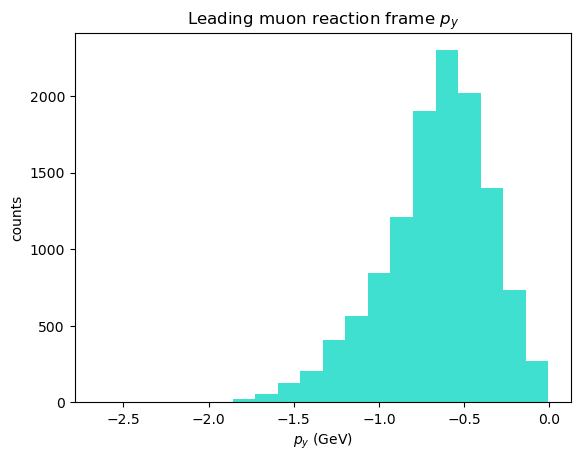

In [8]:
# Make histogram for leading muon's py:
plt.Figure(figsize=(6,4))
plt.hist(df['leading_muon_py'],bins=20, color = 'turquoise')
plt.title('Leading muon reaction frame $p_y$')
plt.xlabel('$p_y$ (GeV)')
plt.ylabel('counts')
plt.show()